# Demo 6 - Deep Learning - Convolutional Neural Networks (CNNs)

### Cybersecurity MBA - Inteligência Artificial e Machine Learning (SEG)

### Classificador para Detecção de Intrusões

* Mais informações em: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html *

* http://kdd.ics.uci.edu/databases/kddcup99/task.html *

In [1]:
# Montando o google drive para salvar nosso modelo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, LSTM
from sklearn.model_selection import train_test_split
from keras import utils as np_utils
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from keras.models import load_model
import tensorflow as tf

In [3]:
# Upload de nosso arquivo. Ref. - http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kddcup.data_10_percent_corrected to kddcup.data_10_percent_corrected
User uploaded file "kddcup.data_10_percent_corrected" with length 74889749 bytes


In [4]:
header = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [5]:
data = pd.read_csv('kddcup.data_10_percent_corrected', names=header)
data.drop_duplicates(subset=None, keep='first', inplace=True)
data.head(15)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.


In [6]:
print(data['label'].value_counts())

normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: label, dtype: int64


In [7]:
pt_le = preprocessing.LabelEncoder()
s_le = preprocessing.LabelEncoder()
f_le = preprocessing.LabelEncoder()
label = preprocessing.LabelEncoder()

data['protocol_type'] = pt_le.fit_transform(data['protocol_type'])
data['service'] = s_le.fit_transform(data['service'])
data['flag'] = f_le.fit_transform(data['flag'])
data['label'] = label.fit_transform(data['label'])

protocol_type_mapping = dict(zip(pt_le.classes_, range(0, len(pt_le.classes_))))
service_mapping = dict(zip(s_le.classes_, range(0, len(s_le.classes_))))
flag_mapping = dict(zip(f_le.classes_, range(0, len(f_le.classes_))))
label_mapping = dict(zip(label.classes_, range(0, len(label.classes_))))

print(protocol_type_mapping)
print(service_mapping)
print(flag_mapping)
print(label_mapping)
dataset = data.values

X = dataset[:, :-1]
y = dataset[:,-1]

scaler = Normalizer().fit(X)
X_norm = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

{'icmp': 0, 'tcp': 1, 'udp': 2}
{'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pm_dump': 41, 'pop_2': 42, 'pop_3': 43, 'printer': 44, 'private': 45, 'red_i': 46, 'remote_job': 47, 'rje': 48, 'shell': 49, 'smtp': 50, 'sql_net': 51, 'ssh': 52, 'sunrpc': 53, 'supdup': 54, 'systat': 55, 'telnet': 56, 'tftp_u': 57, 'tim_i': 58, 'time': 59, 'urh_i': 60, 'urp_i': 61, 'uucp': 62, 'uucp_path': 63, 'vmnet': 64, 'whois': 65}
{'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTOS0': 3, 'RSTR': 4, 'S0': 5, 'S1': 6, 'S2

In [8]:
data.head(15)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,22,9,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,11
1,0,1,22,9,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,11
2,0,1,22,9,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,11
3,0,1,22,9,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,11
4,0,1,22,9,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,11
5,0,1,22,9,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,11
6,0,1,22,9,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,11
7,0,1,22,9,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,11
8,0,1,22,9,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,11
9,0,1,22,9,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,11


In [9]:
print(data['label'].value_counts())

11    87832
9     51820
0       968
20      918
17      906
21      893
5       651
18      641
15      416
14      206
10      158
3        53
1        30
22       20
6        19
4        12
16       10
7         9
2         8
8         7
13        4
12        3
19        2
Name: label, dtype: int64


In [10]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight="balanced",
                                        classes = np.unique(y_train),
                                        y= y_train
                                    )

class_weights = {i : class_weights[i] for i in range(23)}
print(class_weights)

{0: 6.715949717448968, 1: 210.9927536231884, 2: 1012.7652173913043, 3: 120.5672877846791, 4: 506.38260869565215, 5: 9.79463459759482, 6: 281.32367149758454, 7: 562.6473429951691, 8: 723.4037267080745, 9: 0.12203754969288383, 10: 42.55316039459262, 11: 0.07211167564234174, 12: 2531.913043478261, 13: 1687.9420289855072, 14: 30.141821946169774, 15: 15.581003344481605, 16: 562.6473429951691, 17: 6.880198487712666, 18: 9.756890340956689, 19: 2531.913043478261, 20: 6.984587706146926, 21: 6.843008225616921, 22: 281.32367149758454}


In [11]:
nb_classes = 23
y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

lstm_output_size = 70

model = Sequential()
model.add(Convolution1D(64, 3, activation="relu",input_shape=(41, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(128, 3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(lstm_output_size))
model.add(Dropout(0.01))
model.add(Dense(23, activation="softmax"))

initial_epochs = 100
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [13]:
history = model.fit(X_train, y_train,epochs=initial_epochs,class_weight=class_weights,validation_data=(X_test, y_test),verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3640/3640 - 31s - loss: 2.9371 - accuracy: 0.3777 - val_loss: 2.3852 - val_accuracy: 0.4724 - 31s/epoch - 8ms/step
Epoch 2/100
3640/3640 - 18s - loss: 2.3896 - accuracy: 0.3672 - val_loss: 2.2681 - val_accuracy: 0.3522 - 18s/epoch - 5ms/step
Epoch 3/100
3640/3640 - 18s - loss: 2.0787 - accuracy: 0.3642 - val_loss: 1.9574 - val_accuracy: 0.4295 - 18s/epoch - 5ms/step
Epoch 4/100
3640/3640 - 18s - loss: 1.8830 - accuracy: 0.4187 - val_loss: 1.9551 - val_accuracy: 0.4109 - 18s/epoch - 5ms/step
Epoch 5/100
3640/3640 - 17s - loss: 1.7420 - accuracy: 0.4444 - val_loss: 1.9364 - val_accuracy: 0.4142 - 17s/epoch - 5ms/step
Epoch 6/100
3640/3640 - 18s - loss: 1.6298 - accuracy: 0.4675 - val_loss: 1.6937 - val_accuracy: 0.5056 - 18s/epoch - 5ms/step
Epoch 7/100
3640/3640 - 18s - loss: 1.5257 - accuracy: 0.4936 - val_loss: 1.6287 - val_accuracy: 0.5267 - 18s/epoch - 5ms/step
Epoch 8/100
3640/3640 - 18s - loss: 1.4848 - accuracy: 0.5123 - val_loss: 1.4654 - val_accuracy: 0.5394 - 18s/epoch - 5ms/s

In [14]:
model.save('/content/drive/MyDrive/kddcup99_model20210425_100EP.h5')

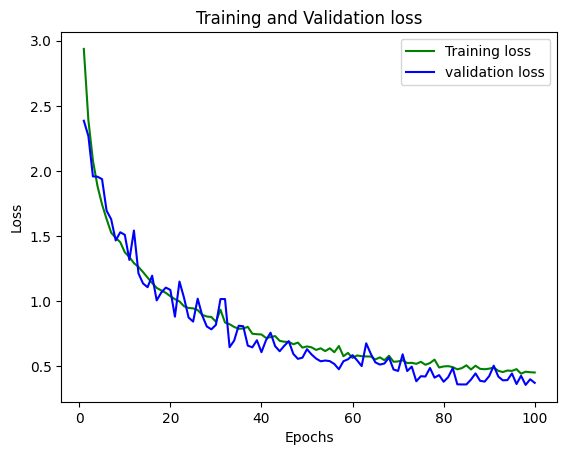

In [15]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,initial_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

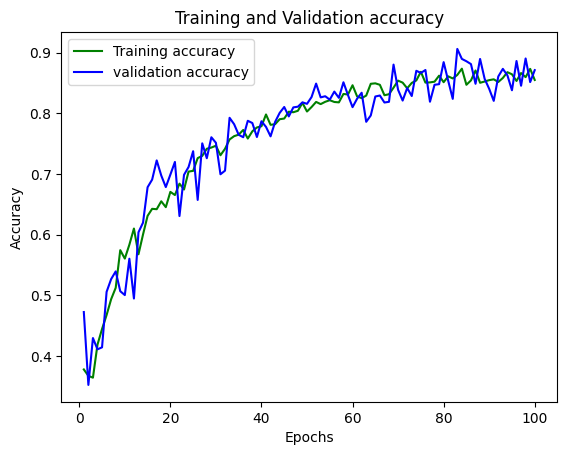

In [16]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,initial_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
header = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

protocol_mapping = {'icmp': 0, 'tcp': 1, 'udp': 2}
service_mapping = {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pm_dump': 41, 'pop_2': 42, 'pop_3': 43, 'printer': 44, 'private': 45, 'red_i': 46, 'remote_job': 47, 'rje': 48, 'shell': 49, 'smtp': 50, 'sql_net': 51, 'ssh': 52, 'sunrpc': 53, 'supdup': 54, 'systat': 55, 'telnet': 56, 'tftp_u': 57, 'tim_i': 58, 'time': 59, 'urh_i': 60, 'urp_i': 61, 'uucp': 62, 'uucp_path': 63, 'vmnet': 64, 'whois': 65}
flag_mapping = {'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTOS0': 3, 'RSTR': 4, 'S0': 5, 'S1': 6, 'S2': 7, 'S3': 8, 'SF': 9, 'SH': 10}
label_mapping = {'back.': 0, 'buffer_overflow.': 1, 'ftp_write.': 2, 'guess_passwd.': 3, 'imap.': 4, 'ipsweep.': 5, 'land.': 6, 'loadmodule.': 7, 'multihop.': 8, 'neptune.': 9, 'nmap.': 10, 'normal.': 11, 'perl.': 12, 'phf.': 13, 'pod.': 14, 'portsweep.': 15, 'rootkit.': 16, 'satan.': 17, 'smurf.': 18, 'spy.': 19, 'teardrop.': 20, 'warezclient.': 21, 'warezmaster.': 22}

test_data = pd.read_csv('kddcup.data_10_percent_corrected',names=header)

test_data['protocol_type'] = test_data['protocol_type'].map(protocol_mapping)
test_data['service'] = test_data['service'].map(service_mapping)
test_data['flag'] = test_data['flag'].map(flag_mapping)

model = load_model('/content/drive/MyDrive/kddcup99_model20210425_100EP.h5')

test_dataset = test_data.values

for data in test_dataset:
  X = data[:-1]
  y = data[-1]

  X = X.reshape(1, -1)
  scaler = Normalizer().fit(X)
  X_norm = scaler.transform(X)

  data = np.reshape(X_norm, (X_norm.shape[0],X_norm.shape[1],1))

  prediction = np.argmax(model.predict(data), axis=-1)
  print("Prediction: " + list(label_mapping.keys())[list(label_mapping.values()).index(prediction[0])] + "\tActual:"+y)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 20ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 19ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 21ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 20ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 19ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 19ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 19ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 20ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 19ms/step
Prediction: smurf.	Actual:smurf.
1/1 [==============================] - 0s 20ms/step
Prediction: smurf.	Actual:smurf.
1/1 [=========